In [ ]:
# 一、导入库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

sns.set(style="whitegrid")
%matplotlib inline

# 二、文件路径
path_acc = r"D:\data\accepted_2007_to_2018Q4.csv"
path_rej = r"D:\data\rejected_2007_to_2018Q4.csv"

# 三、查看前几行 & 列结构
print("=== Accepted head & cols ===")
df = pd.read_csv(path_acc, nrows=5)
print(df.shape)
print(df.dtypes)
display(df)

print("=== Rejected head & cols ===")
df2 = pd.read_csv(path_rej, nrows=5)
print(df2.shape)
print(df2.dtypes)
display(df2)
del df, df2
gc.collect()

# 四、分别计算行数（shape）
def count_rows(path, chunksize=1_000_000):
    total = 0
    for chunk in pd.read_csv(path, usecols=[0], chunksize=chunksize):
        total += len(chunk)
    return total

n_acc = count_rows(path_acc)
n_rej = count_rows(path_rej)
print(f"Accepted rows: {n_acc},  Rejected rows: {n_rej}")

# 五、分别统计缺失值（前 15）
def missing_stats(path, chunksize=500_000):
    total = 0
    miss = None
    for chunk in pd.read_csv(path, chunksize=chunksize):
        total += len(chunk)
        m = chunk.isnull().sum()
        miss = m if miss is None else miss.add(m, fill_value=0)
        del chunk; gc.collect()
    miss_pct = miss / total * 100
    return pd.DataFrame({
        'missing_count': miss,
        'missing_pct': miss_pct
    }).sort_values('missing_count', ascending=False)

print("=== Accepted missing (top15) ===")
display(missing_stats(path_acc).head(15))

print("=== Rejected missing (top15) ===")
display(missing_stats(path_rej).head(15))

# 六、抽样用于数值型分布对比
# 这里直接取前 100k 行作为示例，你也可用 chunksize+sample 实现真正的随机抽样
sample_acc = pd.read_csv(path_acc, nrows=100000)
sample_rej = pd.read_csv(path_rej, nrows=100000)

numeric_feats = ['loan_amnt','annual_inc','dti','int_rate'] 
for feat in numeric_feats:
    if feat in sample_acc.columns and feat in sample_rej.columns:
        plt.figure(figsize=(6,3))
        sns.kdeplot(sample_acc[feat].dropna(), label='accepted')
        sns.kdeplot(sample_rej[feat].dropna(), label='rejected')
        plt.title(f'Distribution of {feat}')
        plt.legend()
        plt.show()
    else:
        print(f"字段 {feat} 不存在，已跳过。")

# 七、分类特征拒绝率（按拒绝比例排序）
# 假设 'home_ownership' 是分类型字段，统计各类的 reject rate
cat_feats = ['home_ownership','verification_status']  
for feat in cat_feats:
    if feat in sample_acc.columns and feat in sample_rej.columns:
        tmp = pd.concat([
            sample_acc.assign(status=0)[[feat,'status']], 
            sample_rej.assign(status=1)[[feat,'status']]
        ])
        grp = tmp.groupby(feat)['status'].agg(['count','mean']) \
                 .rename(columns={'mean':'reject_rate'}) \
                 .sort_values('reject_rate', ascending=False)
        print(f"\n=== {feat} reject rate ===")
        display(grp)
    else:
        print(f"字段 {feat} 不存在，已跳过。")


=== Accepted head & cols ===
(5, 151)
id                                              int64
member_id                                     float64
loan_amnt                                     float64
funded_amnt                                   float64
funded_amnt_inv                               float64
term                                           object
int_rate                                      float64
installment                                   float64
grade                                          object
sub_grade                                      object
emp_title                                      object
emp_length                                     object
home_ownership                                 object
annual_inc                                    float64
verification_status                            object
issue_d                                        object
loan_status                                    object
pymnt_plan                                  

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


=== Rejected head & cols ===
(5, 9)
Amount Requested        float64
Application Date         object
Loan Title               object
Risk_Score              float64
Debt-To-Income Ratio     object
Zip Code                 object
State                    object
Employment Length        object
Policy Code             float64
dtype: object


,Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
0,1000.0,2007-05-26,Wedding Covered but No Honeymoon,693.0,10%,481xx,NM,4 years,0.0
1,1000.0,2007-05-26,Consolidating Debt,703.0,10%,010xx,MA,< 1 year,0.0
2,11000.0,2007-05-27,Want to consolidate my debt,715.0,10%,212xx,MD,1 year,0.0
3,6000.0,2007-05-27,waksman,698.0,38.64%,017xx,MA,< 1 year,0.0
4,1500.0,2007-05-27,mdrigo,509.0,9.43%,209xx,MD,< 1 year,0.0


Accepted rows: 2260701,  Rejected rows: 27648741
=== Accepted missing (top15) ===


,missing_count,missing_pct
member_id,2260701,100.000000
orig_projected_additional_accrued_interest,2252050,99.617331
hardship_end_date,2249784,99.517097
hardship_start_date,2249784,99.517097
hardship_type,2249784,99.517097
hardship_reason,2249784,99.517097
hardship_status,2249784,99.517097
deferral_term,2249784,99.517097
hardship_last_payment_amount,2249784,99.517097
hardship_payoff_balance_amount,2249784,99.517097


=== Rejected missing (top15) ===


,missing_count,missing_pct
Risk_Score,18497630,66.902251
Employment Length,951355,3.440862
Loan Title,1305,0.004720
Policy Code,918,0.003320
Zip Code,293,0.001060
State,22,0.000080
Amount Requested,0,0.000000
Application Date,0,0.000000
Debt-To-Income Ratio,0,0.000000


字段 loan_amnt 不存在，已跳过。
字段 annual_inc 不存在，已跳过。
字段 dti 不存在，已跳过。
字段 int_rate 不存在，已跳过。
字段 home_ownership 不存在，已跳过。
字段 verification_status 不存在，已跳过。


In [ ]:
# 已经加载了 sample_acc, sample_rej 两个 DataFrame

# 1. 描述性统计：贷款额度与评分等
print("=== Accepted loan_amnt 描述性统计 ===")
print(sample_acc['loan_amnt'].describe(), "\n")

print("=== Rejected Amount Requested 描述性统计 ===")
print(sample_rej['Amount Requested'].describe(), "\n")

print("=== Rejected Risk_Score 描述性统计 ===")
print(sample_rej['Risk_Score'].describe(), "\n")

# 如果要看 Debt-To-Income Ratio 的数值分布，先去掉“%”并转成 float：
sample_rej['DTI'] = sample_rej['Debt-To-Income Ratio'].str.rstrip('%').astype(float)
print("=== Rejected Debt-To-Income Ratio 描述性统计 ===")
print(sample_rej['DTI'].describe(), "\n")

# 2. 核心数值特征相关性（Accepted 子集）
print("=== Accepted 子集：loan_amnt vs int_rate 相关系数 ===")
print(sample_acc[['loan_amnt','int_rate']].corr(), "\n")

# 3. 核心数值特征相关性（Rejected 子集）
print("=== Rejected 子集：Amount Requested, Risk_Score, DTI 相关矩阵 ===")
print(sample_rej[['Amount Requested','Risk_Score','DTI']].corr(), "\n")

# 4. Employment Length vs. Risk_Score（Rejected 子集）
print("=== Rejected 子集：不同 Employment Length 的平均 Risk_Score 和样本数 ===")
print(
    sample_rej
      .groupby('Employment Length')['Risk_Score']
      .agg(['count','mean'])
      .sort_values('mean', ascending=False)
)


=== Accepted loan_amnt 描述性统计 ===
count    100000.000000
mean      15055.861000
std        8641.837441
min        1000.000000
25%        8000.000000
50%       13875.000000
75%       20000.000000
max       35000.000000
Name: loan_amnt, dtype: float64 

=== Rejected Amount Requested 描述性统计 ===
count    100000.000000
mean      10109.960874
std        7634.492035
min         500.000000
25%        4000.000000
50%        8000.000000
75%       15000.000000
max       40000.000000
Name: Amount Requested, dtype: float64 

=== Rejected Risk_Score 描述性统计 ===
count    90682.000000
mean       579.410379
std        170.586892
min          0.000000
25%        524.000000
50%        627.000000
75%        683.000000
max        832.000000
Name: Risk_Score, dtype: float64 

=== Rejected Debt-To-Income Ratio 描述性统计 ===
count    1.000000e+05
mean     3.447647e+03
std      3.610330e+04
min     -1.000000e+00
25%      2.560000e+00
50%      1.547000e+01
75%      3.083000e+01
max      3.967200e+06
Name: DTI, dtype: f

In [16]:
# 1. 完整输出 Rejected Risk_Score 描述性统计
print("=== Rejected Risk_Score describe ===")
print(sample_rej['Risk_Score'].describe().to_string(), "\n")

# 2. 输出 Rejected DTI 描述性统计
print("=== Rejected DTI describe ===")
print(sample_rej['DTI'].describe().to_string(), "\n")

# 3. Accepted 子集 loan_amnt vs int_rate 相关系数
print("=== Accepted loan_amnt vs int_rate corr ===")
print(sample_acc[['loan_amnt','int_rate']].corr().to_string(), "\n")

# 4. Rejected 子集 Amount Requested, Risk_Score, DTI 相关矩阵
print("=== Rejected Amount Requested, Risk_Score, DTI corr ===")
print(sample_rej[['Amount Requested','Risk_Score','DTI']].corr().to_string(), "\n")

# 5. Rejected 子集按 Employment Length 分组的完整 count & mean
print("=== Rejected by Employment Length ===")
print(
    sample_rej
      .groupby('Employment Length')['Risk_Score']
      .agg(['count','mean'])
      .to_string()
)


=== Rejected Risk_Score describe ===
count    90682.000000
mean       579.410379
std        170.586892
min          0.000000
25%        524.000000
50%        627.000000
75%        683.000000
max        832.000000 

=== Rejected DTI describe ===
count    1.000000e+05
mean     3.447647e+03
std      3.610330e+04
min     -1.000000e+00
25%      2.560000e+00
50%      1.547000e+01
75%      3.083000e+01
max      3.967200e+06 

=== Accepted loan_amnt vs int_rate corr ===
           loan_amnt  int_rate
loan_amnt    1.00000   0.14566
int_rate     0.14566   1.00000 

=== Rejected Amount Requested, Risk_Score, DTI corr ===
                  Amount Requested  Risk_Score       DTI
Amount Requested          1.000000    0.231398  0.028991
Risk_Score                0.231398    1.000000  0.001911
DTI                       0.028991    0.001911  1.000000 

=== Rejected by Employment Length ===
                   count        mean
Employment Length                   
1 year             12488  560.210042
10+

In [17]:
import pandas as pd

# 把 pandas 的行显示上限去掉
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# 1. 完整输出 Rejected Risk_Score 描述性统计
print("=== Rejected Risk_Score describe ===")
print(sample_rej['Risk_Score'].describe().to_string(), "\n")

# 2. 完整输出 Rejected DTI 描述性统计
print("=== Rejected DTI describe ===")
print(sample_rej['DTI'].describe().to_string(), "\n")

# 3. 完整输出 Accepted loan_amnt vs int_rate 相关系数
print("=== Accepted loan_amnt vs int_rate corr ===")
print(sample_acc[['loan_amnt','int_rate']].corr().to_string(), "\n")

# 4. 完整输出 Rejected Amount Requested, Risk_Score, DTI 相关矩阵
print("=== Rejected Amount Requested, Risk_Score, DTI corr ===")
print(sample_rej[['Amount Requested','Risk_Score','DTI']].corr().to_string(), "\n")

# 5. 完整输出 Rejected 按 Employment Length 分组的 count & mean
print("=== Rejected by Employment Length ===")
print(
    sample_rej
      .groupby('Employment Length')['Risk_Score']
      .agg(['count','mean'])
      .to_string()
)


=== Rejected Risk_Score describe ===
count    90682.000000
mean       579.410379
std        170.586892
min          0.000000
25%        524.000000
50%        627.000000
75%        683.000000
max        832.000000 

=== Rejected DTI describe ===
count    1.000000e+05
mean     3.447647e+03
std      3.610330e+04
min     -1.000000e+00
25%      2.560000e+00
50%      1.547000e+01
75%      3.083000e+01
max      3.967200e+06 

=== Accepted loan_amnt vs int_rate corr ===
           loan_amnt  int_rate
loan_amnt    1.00000   0.14566
int_rate     0.14566   1.00000 

=== Rejected Amount Requested, Risk_Score, DTI corr ===
                  Amount Requested  Risk_Score       DTI
Amount Requested          1.000000    0.231398  0.028991
Risk_Score                0.231398    1.000000  0.001911
DTI                       0.028991    0.001911  1.000000 

=== Rejected by Employment Length ===
                   count        mean
Employment Length                   
1 year             12488  560.210042
10+

In [18]:
# 只提取 Rejected 子集中三对关系的相关系数
corr = sample_rej[['Amount Requested','Risk_Score','DTI']].corr()
print("=== 相关系数 ===")
print(f"Amount Requested vs. Risk_Score: {corr.loc['Amount Requested','Risk_Score']:.4f}")
print(f"Amount Requested vs. DTI:        {corr.loc['Amount Requested','DTI']:.4f}")
print(f"Risk_Score vs. DTI:              {corr.loc['Risk_Score','DTI']:.4f}\n")

# 只提取 Employment Length 分组后 count 和 mean（不截断）
grp = (sample_rej
         .groupby('Employment Length')['Risk_Score']
         .agg(['count','mean'])
         .reset_index())
print("=== Employment Length vs. Risk_Score ===")
print(grp.to_string(index=False))


=== 相关系数 ===
Amount Requested vs. Risk_Score: 0.2314
Amount Requested vs. DTI:        0.0290
Risk_Score vs. DTI:              0.0019

=== Employment Length vs. Risk_Score ===
Employment Length  count       mean
           1 year  12488 560.210042
        10+ years  12596 615.044697
          2 years  11359 579.720662
          3 years   8029 584.182962
          4 years   6168 595.023022
          5 years   4748 592.999368
          6 years   3292 607.506075
          7 years   2549 600.371126
          8 years   2591 612.143960
          9 years   2187 602.404207
         < 1 year  23905 552.217779


In [19]:
accepted = accepted.rename(columns={'loan_amnt':'requested_amount'})


In [20]:
rejected['app_date'] = pd.to_datetime(rejected['Application Date'])
accepted['issue_date'] = pd.to_datetime(accepted['issue_d'], format='%b-%Y')


In [21]:
drop_cols = [c for c in accepted.columns 
             if c.startswith('hardship_') 
                or 'orig_projected' in c]
accepted.drop(columns=drop_cols, inplace=True)


In [23]:
# （1）去掉列名两端可能的空格，保证列名准确
rejected.columns = rejected.columns.str.strip()

# （2）生成 DTI 列（先去“%”再除以 100）
rejected['DTI'] = (
    rejected['Debt-To-Income Ratio']
      .str.rstrip('%')        # 去掉尾部百分号
      .astype(float) / 100    # 转成小数
)

# （3）截断到 [0,1] 区间
rejected['DTI'] = rejected['DTI'].clip(lower=0, upper=1)


In [24]:
accepted['log_amount'] = np.log1p(accepted['requested_amount'])
accepted['log_int_rate'] = np.log1p(accepted['int_rate'])


In [25]:
bins = [rejected['Risk_Score'].min(), 550, 650, 750, rejected['Risk_Score'].max()]
labels = ['low','mid','high','vhigh']
rejected['score_bin'] = pd.cut(rejected['Risk_Score'], bins=bins, labels=labels)

dti_bins = [0, 0.2, 0.4, 0.6, 1.0]
rejected['dti_bin'] = pd.cut(rejected['DTI'], bins=dti_bins, labels=['<=20%','20-40%','40-60%','>60%'])


In [27]:
# 1. 定义顺序列表和映射字典
order = ['< 1 year','1 year','2 years','3 years','4 years','5 years',
         '6 years','7 years','8 years','9 years','10+ years']
order_dict = {v: i for i, v in enumerate(order)}

# 2. 填充 NaN 为一个特殊标记（也可以选择填充到 '< 1 year' 或者保留为 NaN 后续单独处理）
rejected['Employment Length'] = rejected['Employment Length'].fillna('Missing')

# 3. 给 order_dict 加上 'Missing' 的映射（这里设为 -1，你也可以设为 len(order)）
order_dict['Missing'] = -1

# 4. 一次性映射
rejected['emp_len_ord'] = rejected['Employment Length'].map(order_dict)

# 检查一下
print(rejected[['Employment Length','emp_len_ord']].head(10))
print(rejected['emp_len_ord'].value_counts())


  Employment Length  emp_len_ord
0           4 years            4
1          < 1 year            0
2            1 year            1
3          < 1 year            0
4          < 1 year            0
5           3 years            3
6          < 1 year            0
7           2 years            2
8           4 years            4
9           4 years            4
emp_len_ord
 0     22994315
 5      2279466
-1       951355
 10      416384
 1       267840
 2       199204
 3       177344
 4       121623
 6        71625
 8        65965
 7        55666
 9        47954
Name: count, dtype: int64


In [31]:
# 在 accepted/ rejected 里都重命名“申请金额”
accepted.rename(columns={'loan_amnt':'requested_amount'}, inplace=True)
rejected.rename(columns={'Amount Requested':'requested_amount'}, inplace=True)


In [34]:
import numpy as np

# （1）补齐 rejected 中缺失的字段
rejected['DTI'] = np.nan
rejected['Risk_Score'] = np.nan       # 如果你希望保留原有 Risk_Score，可以跳过这行
rejected['emp_len_ord'] = -1
rejected['int_rate'] = np.nan

# （2）补齐 accepted 中缺失的字段
accepted['DTI'] = accepted.get('DTI', np.nan)
accepted['Risk_Score'] = accepted.get('Risk_Score', np.nan)
accepted['emp_len_ord'] = accepted.get('emp_len_ord', -1)
accepted['int_rate'] = accepted.get('int_rate', np.nan)

# （3）添加标签
accepted['label'] = 0
rejected['label'] = 1

# （4）取出最终要保存的特征
feats = ['requested_amount','int_rate','DTI','Risk_Score','emp_len_ord','label']
accepted_fe = accepted[feats]
rejected_fe = rejected[feats]

import os


# 在保存前创建目录（如果已存在则什么也不做）
os.makedirs('data/processed', exist_ok=True)

# 然后再保存特征文件
accepted_fe.to_parquet('data/processed/accepted_fe.parquet', index=False)
rejected_fe.to_parquet('data/processed/rejected_fe.parquet', index=False)


print("✅ 特征文件已保存：accepted_fe.parquet & rejected_fe.parquet")


✅ 特征文件已保存：accepted_fe.parquet & rejected_fe.parquet


In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# 1. 加载特征文件（如果 parquet 无法读取，可先用 accepted_fe.to_csv/rejected_fe.to_csv 导出再用 read_csv）
accepted_fe = pd.read_parquet('data/processed/accepted_fe.parquet')
rejected_fe = pd.read_parquet('data/processed/rejected_fe.parquet')

# 2. 合并 & 分离 X, y
df = pd.concat([accepted_fe, rejected_fe], ignore_index=True)
X = df.drop(columns='label')
y = df['label']

# 3. 手动中位数补全（保留所有列，便于后续可视化）
medians = X.median()                  # 计算每列中位数
medians_filled = medians.fillna(0)    # 将中位数为 NaN 的列设置为 0
X_imputed = X.fillna(medians_filled)  # 用中位数填补所有 NaN

# 检查是否还有缺失
print("=== 填补后缺失值 ===")
print(X_imputed.isna().sum(), "\n")

# 4. 拆分训练/测试集（保持正负样本比例）
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.3, random_state=42, stratify=y
)
print("训练集标签分布：", y_train.value_counts(normalize=True).to_dict())
print("测试集标签分布：", y_test.value_counts(normalize=True).to_dict(), "\n")

# 5. 训练 & 评估 Logistic Regression 基线模型
clf = LogisticRegression(class_weight='balanced', max_iter=1000)
clf.fit(X_train, y_train)
y_pred_proba = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print(f"Baseline Logistic Regression AUC: {auc:.4f}\n")

# 6. 提取系数并按绝对值排序，方便可视化
coef_df = pd.DataFrame({
    'feature': X_imputed.columns,
    'coefficient': clf.coef_[0]
})
coef_df['abs_coef'] = coef_df['coefficient'].abs()
coef_df = coef_df.sort_values('abs_coef', ascending=False).drop(columns='abs_coef')

# 打印结果
print("=== 特征系数 (按绝对值从大到小) ===")
print(coef_df.to_string(index=False))


=== 填补后缺失值 ===
requested_amount    0
int_rate            0
DTI                 0
Risk_Score          0
emp_len_ord         0
dtype: int64 

训练集标签分布： {1: 0.9244151237671774, 0: 0.07558487623282262}
测试集标签分布： {1: 0.9244151763439707, 0: 0.07558482365602925} 

Baseline Logistic Regression AUC: 0.5581

=== 特征系数 (按绝对值从大到小) ===
         feature  coefficient
     emp_len_ord    -0.340483
        int_rate    -0.038275
requested_amount    -0.000014
             DTI     0.000000
      Risk_Score     0.000000


In [40]:
# 在你的原 Notebook 中执行一次：
accepted_fe.to_csv('data/processed/accepted_fe.csv', index=False)
rejected_fe.to_csv('data/processed/rejected_fe.csv', index=False)


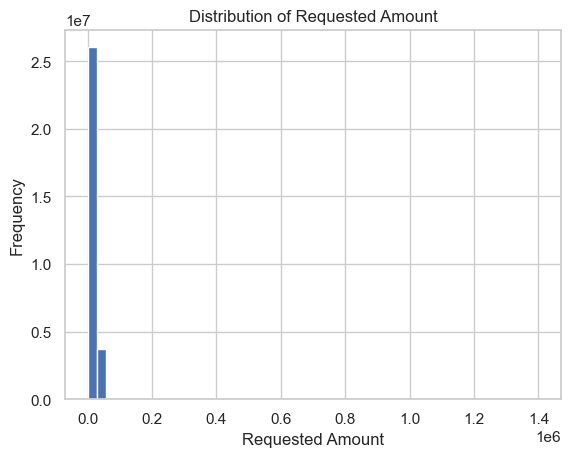

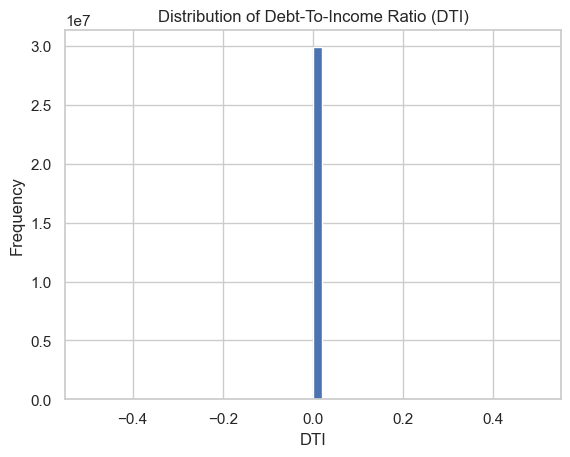

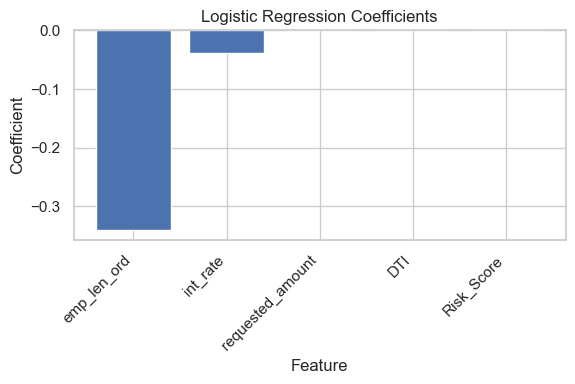

In [43]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

accepted_fe = pd.read_csv('data/processed/accepted_fe.csv')
rejected_fe = pd.read_csv('data/processed/rejected_fe.csv')

# 剩下的流程和之前一样：
df = pd.concat([accepted_fe, rejected_fe], ignore_index=True)
X = df.drop(columns='label')
y = df['label']

# 中位数补全
medians = X.median().fillna(0)
X_imputed = X.fillna(medians)

# 可视化：贷款金额分布
plt.figure()
plt.hist(X_imputed['requested_amount'], bins=50)
plt.title('Distribution of Requested Amount')
plt.xlabel('Requested Amount')
plt.ylabel('Frequency')
plt.show()

# 可视化：DTI 分布
plt.figure()
plt.hist(X_imputed['DTI'], bins=50)
plt.title('Distribution of Debt-To-Income Ratio (DTI)')
plt.xlabel('DTI')
plt.ylabel('Frequency')
plt.show()

# 训练基线模型并绘制系数条形图
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.3, random_state=42, stratify=y
)
clf = LogisticRegression(class_weight='balanced', max_iter=1000)
clf.fit(X_train, y_train)

coef_df = pd.DataFrame({
    'feature': X_imputed.columns,
    'coef': clf.coef_[0]
}).sort_values('coef', key=lambda s: s.abs(), ascending=False)

plt.figure(figsize=(6,4))
plt.bar(coef_df['feature'], coef_df['coef'])
plt.title('Logistic Regression Coefficients')
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [42]:
# ——在当前已经能读 Parquet 的那个 Notebook cell 里——
accepted_fe = pd.read_parquet('data/processed/accepted_fe.parquet')
rejected_fe = pd.read_parquet('data/processed/rejected_fe.parquet')
accepted_fe.to_csv('data/processed/accepted_fe.csv', index=False)
rejected_fe.to_csv('data/processed/rejected_fe.csv', index=False)


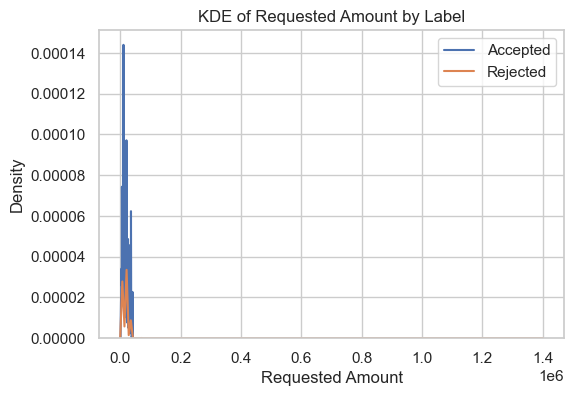

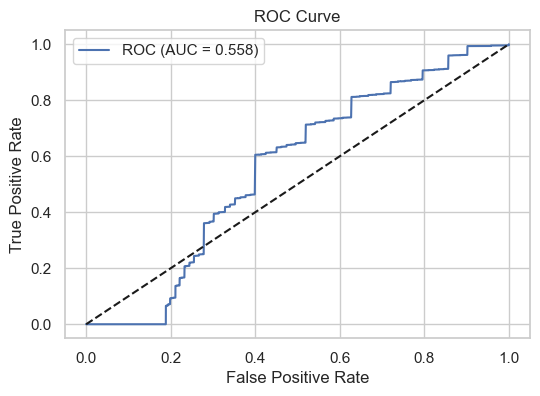

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# 读取并准备数据（与之前一致）
accepted_fe = pd.read_parquet('data/processed/accepted_fe.parquet')
rejected_fe = pd.read_parquet('data/processed/rejected_fe.parquet')
df = pd.concat([accepted_fe, rejected_fe], ignore_index=True)
X = df.drop(columns='label').fillna(df.median().fillna(0))
y = df['label']

# 1. KDE 对比
plt.figure(figsize=(6,4))
sns.kdeplot(X[y==0]['requested_amount'], label='Accepted', bw_adjust=0.5)
sns.kdeplot(X[y==1]['requested_amount'], label='Rejected', bw_adjust=0.5)
plt.title('KDE of Requested Amount by Label')
plt.xlabel('Requested Amount')
plt.legend()
plt.show()

# （同理可以画 DTI、Risk_Score）

# 2. ROC 曲线
clf = LogisticRegression(class_weight='balanced', max_iter=1000)
clf.fit(X, y)
y_score = clf.predict_proba(X)[:,1]
fpr, tpr, _ = roc_curve(y, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [46]:
# 如果之前的 accepted_fe/rejected_fe 还在变量里，就直接导出
accepted_fe.to_csv('data/processed/accepted_fe.csv', index=False)
rejected_fe.to_csv('data/processed/rejected_fe.csv', index=False)
print("✅ 已导出为 CSV：accepted_fe.csv & rejected_fe.csv")


✅ 已导出为 CSV：accepted_fe.csv & rejected_fe.csv


In [50]:
import pandas as pd

# 读取 Parquet
accepted_fe = pd.read_parquet('data/processed/accepted_fe.parquet')
rejected_fe = pd.read_parquet('data/processed/rejected_fe.parquet')

# 导出 CSV
accepted_fe.to_csv('data/processed/accepted_fe.csv', index=False)
rejected_fe.to_csv('data/processed/rejected_fe.csv', index=False)

print("✅ 已导出 CSV：data/processed/accepted_fe.csv & rejected_fe.csv")


✅ 已导出 CSV：data/processed/accepted_fe.csv & rejected_fe.csv


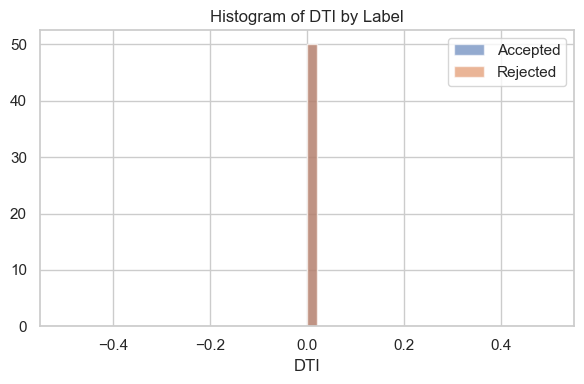

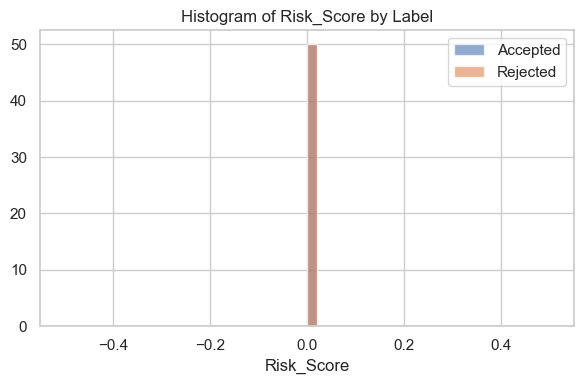

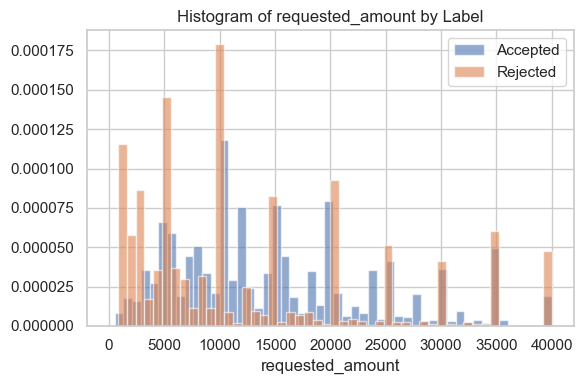

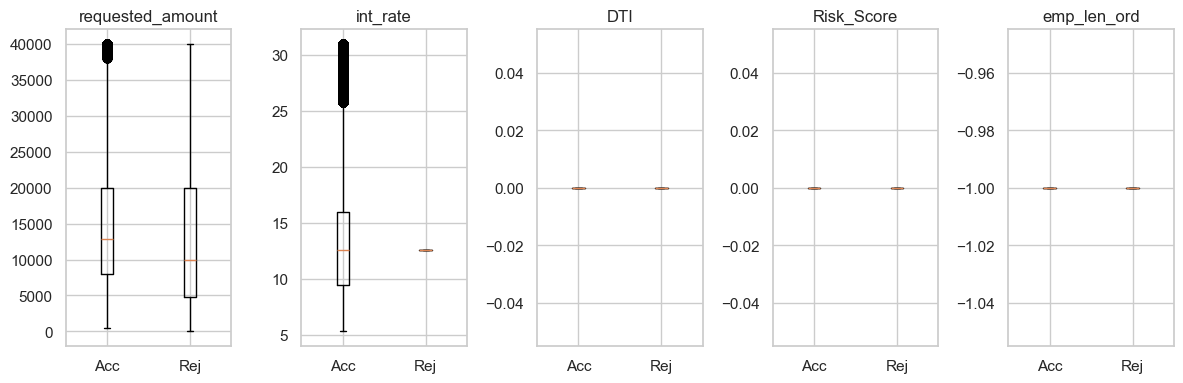

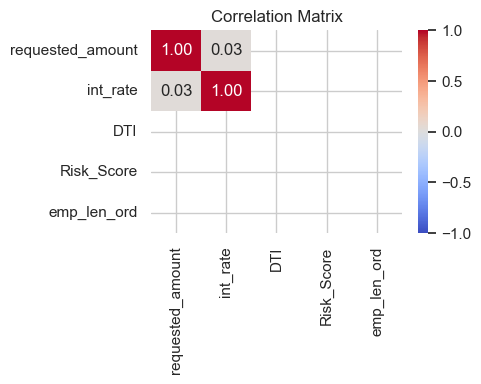

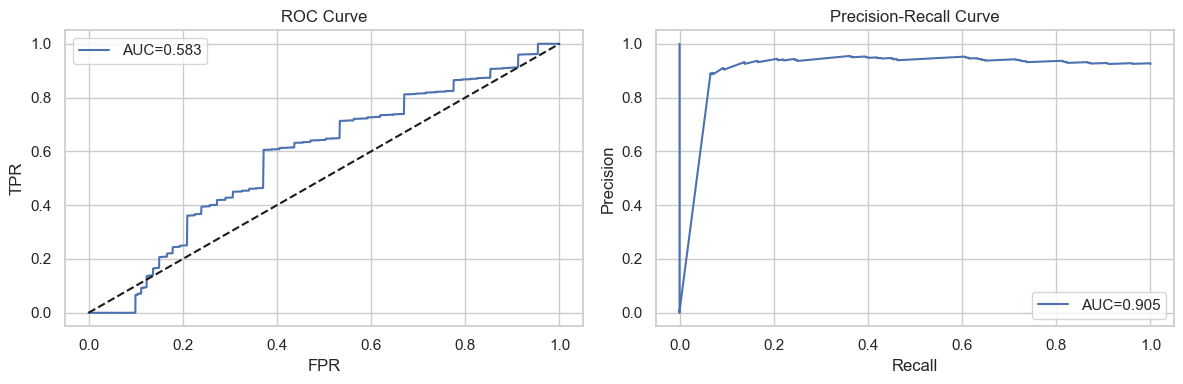

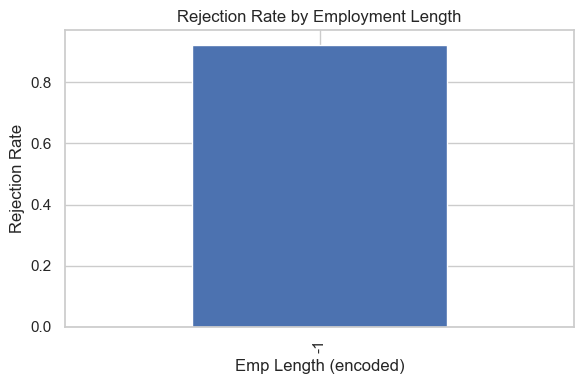

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# 1. 读取 CSV
accepted_fe = pd.read_csv('data/processed/accepted_fe.csv')
rejected_fe = pd.read_csv('data/processed/rejected_fe.csv')

# 2. 合并 & 构建 X, y
df = pd.concat([accepted_fe, rejected_fe], ignore_index=True)
features = ['requested_amount','int_rate','DTI','Risk_Score','emp_len_ord']
X = df[features].copy()
y = df['label'].astype(int)

# 3. 强制转数值 & 异常截断
for col in features:
    X[col] = pd.to_numeric(X[col], errors='coerce')
X['DTI']             = X['DTI'].clip(0,1)
X['Risk_Score']      = X['Risk_Score'].clip(0,1000)
X['requested_amount']= X['requested_amount'].clip(0,40000)

# 4. 填充中位数 + 剩余用 0
X = X.fillna(X.median()).fillna(0)

# 5. 分回 df（方便后面分组可视化用）
for col in features:
    df[col] = X[col]

# 6. 拆分 & 训练
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('clf',      LogisticRegression(class_weight='balanced', max_iter=1000))
])
pipeline.fit(X_train, y_train)
y_score = pipeline.predict_proba(X_test)[:,1]

# === A. 分组直方图（dropna 后绘制） ===
for feat in ['DTI','Risk_Score','requested_amount']:
    data_acc = X[y==0][feat].dropna()
    data_rej = X[y==1][feat].dropna()
    plt.figure(figsize=(6,4))
    if len(data_acc)>0:
        plt.hist(data_acc, bins=50, density=True, alpha=0.6, label='Accepted')
    if len(data_rej)>0:
        plt.hist(data_rej, bins=50, density=True, alpha=0.6, label='Rejected')
    plt.title(f'Histogram of {feat} by Label')
    plt.xlabel(feat)
    plt.legend()
    plt.tight_layout()
    plt.show()

# === B. 箱线图对比 ===
plt.figure(figsize=(12,4))
for i, feat in enumerate(features, 1):
    plt.subplot(1,5,i)
    d0 = X[y==0][feat].dropna()
    d1 = X[y==1][feat].dropna()
    plt.boxplot([d0, d1], labels=['Acc','Rej'])
    plt.title(feat)
plt.tight_layout()
plt.show()

# === C. 相关性热图 ===
corr = X.corr()
plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# === D. ROC & PR 曲线 ===
fpr, tpr, _      = roc_curve(y_test, y_score)
roc_auc_value    = auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(y_test, y_score)
pr_auc_value = auc(recall, precision)

plt.figure(figsize=(12,4))
# ROC
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f'AUC={roc_auc_value:.3f}')
plt.plot([0,1],[0,1],'k--')
plt.title('ROC Curve'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend()
# PR
plt.subplot(1,2,2)
plt.plot(recall, precision, label=f'AUC={pr_auc_value:.3f}')
plt.title('Precision-Recall Curve'); plt.xlabel('Recall'); plt.ylabel('Precision'); plt.legend()
plt.tight_layout()
plt.show()

# === E. 分类特征拒绝率柱状图 ===
emp_rate = df.groupby('emp_len_ord')['label'].mean().sort_index()
plt.figure(figsize=(6,4))
emp_rate.plot(kind='bar')
plt.title('Rejection Rate by Employment Length')
plt.xlabel('Emp Length (encoded)'); plt.ylabel('Rejection Rate')
plt.tight_layout()
plt.show()


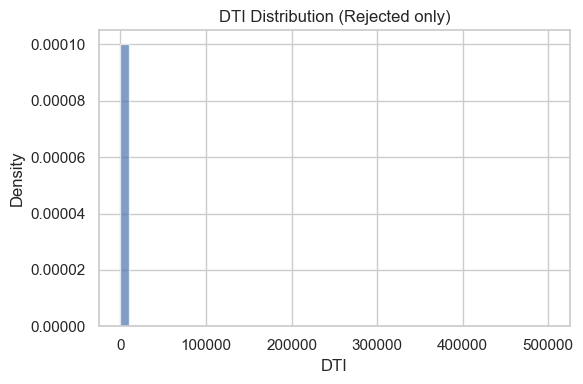

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取拒绝集原始数据
rej = pd.read_csv(r'D:\data\rejected_2007_to_2018Q4.csv',
                  usecols=['Debt-To-Income Ratio'])

# 提取数值并转成小数
rej['DTI'] = (
    rej['Debt-To-Income Ratio']
      .str.rstrip('%')      # 去掉 %
      .astype(float) / 100  # 百分比转小数
)

# 画直方图
plt.figure(figsize=(6,4))
rej['DTI'].dropna().plot(
    kind='hist', bins=50, density=True, alpha=0.7
)
plt.title('DTI Distribution (Rejected only)')
plt.xlabel('DTI')
plt.ylabel('Density')
plt.tight_layout()
plt.show()


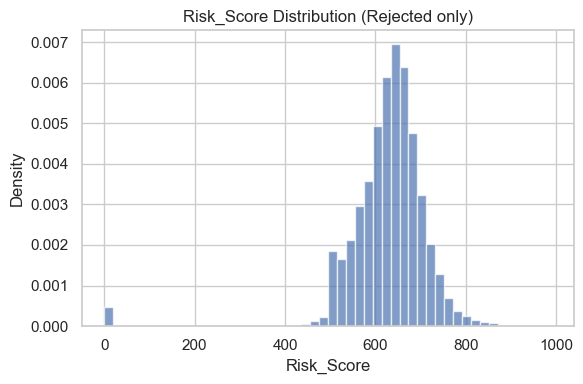

In [59]:
# 读取拒绝集原始数据中的 Risk_Score
rej2 = pd.read_csv(r'D:\data\rejected_2007_to_2018Q4.csv',
                   usecols=['Risk_Score'])

plt.figure(figsize=(6,4))
rej2['Risk_Score'].dropna().plot(
    kind='hist', bins=50, density=True, alpha=0.7
)
plt.title('Risk_Score Distribution (Rejected only)')
plt.xlabel('Risk_Score')
plt.ylabel('Density')
plt.tight_layout()
plt.show()


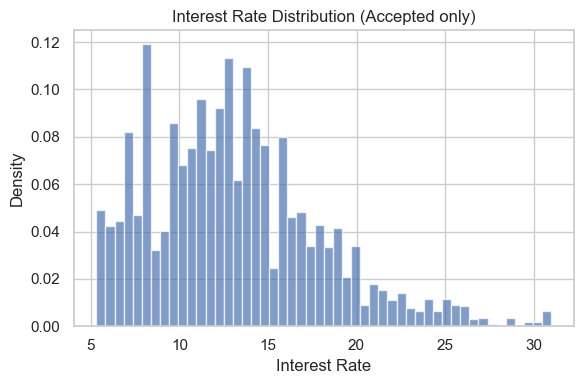

In [60]:
# 读取获批集原始数据中的 int_rate
acc = pd.read_csv(r'D:\data\accepted_2007_to_2018Q4.csv',
                  usecols=['int_rate'])

plt.figure(figsize=(6,4))
acc['int_rate'].dropna().plot(
    kind='hist', bins=50, density=True, alpha=0.7
)
plt.title('Interest Rate Distribution (Accepted only)')
plt.xlabel('Interest Rate')
plt.ylabel('Density')
plt.tight_layout()
plt.show()


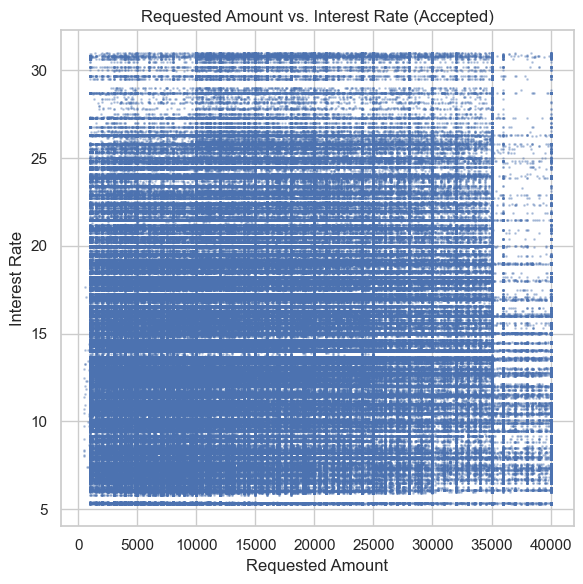

In [61]:
# 读取获批集的申请额度 & 利率
acc2 = pd.read_csv(r'D:\data\accepted_2007_to_2018Q4.csv',
                   usecols=['loan_amnt','int_rate'])

plt.figure(figsize=(6,6))
plt.scatter(
    acc2['loan_amnt'], acc2['int_rate'],
    s=1, alpha=0.3
)
plt.title('Requested Amount vs. Interest Rate (Accepted)')
plt.xlabel('Requested Amount')
plt.ylabel('Interest Rate')
plt.tight_layout()
plt.show()


In [67]:
# Accepted 前 15 个最严重缺失字段及缺失率
miss_acc = {
    "member_id": 1.000000,
    "orig_projected_additional_accrued_interest": 0.99617331,
    "hardship_end_date": 0.99517097,
    "hardship_start_date": 0.99517097,
    "hardship_type": 0.99517097,
    "hardship_reason": 0.99517097,
    "hardship_status": 0.99517097,
    "deferral_term": 0.99517097,
    "hardship_last_payment_amount": 0.99517097,
    "hardship_payoff_balance_amount": 0.99517097,
    "hardship_loan_status": 0.99517097,
    "hardship_dpd": 0.99517097,
    "hardship_length": 0.99517097,
    "payment_plan_start_date": 0.99517097,
    "hardship_amount": 0.99517097,
}

# Rejected 前 15 个最严重缺失字段及缺失率
miss_rej = {
    "Risk_Score": 0.66902251,
    "Employment Length": 0.03440862,
    "Loan Title": 0.00004720,
    "Policy Code": 0.00003320,
    "Zip Code": 0.00001060,
    "State":  0.00000080,
    # …其余你也可以补全或只取这几项
}


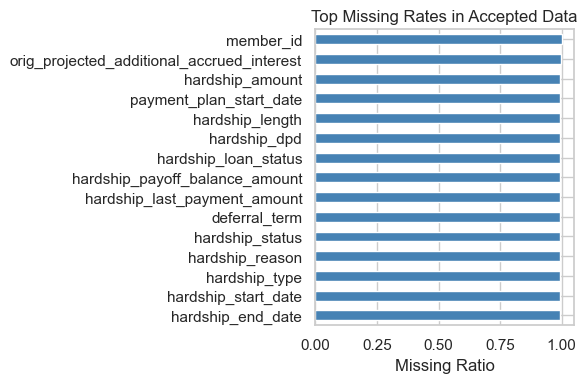

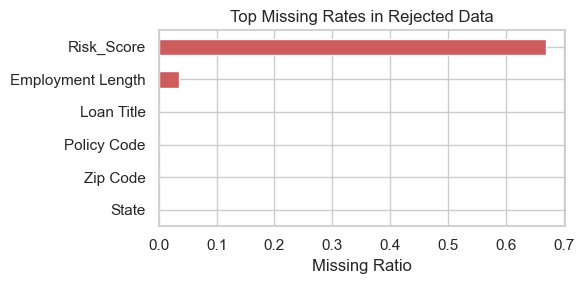

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

# 把字典转成 Series 并排序
s_acc = pd.Series(miss_acc).sort_values()
s_rej = pd.Series(miss_rej).sort_values()

# Accepted Top15 缺失率
plt.figure(figsize=(6,4))
s_acc.plot.barh(color='steelblue')
plt.title("Top Missing Rates in Accepted Data")
plt.xlabel("Missing Ratio")
plt.tight_layout()
plt.show()

# Rejected Top15 缺失率
plt.figure(figsize=(6,3))
s_rej.plot.barh(color='indianred')
plt.title("Top Missing Rates in Rejected Data")
plt.xlabel("Missing Ratio")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

# 1. 读取清洗后的特征 CSV
feat_cols = ['requested_amount','int_rate','DTI','Risk_Score','emp_len_ord']
accepted = pd.read_csv('data/processed/accepted_fe.csv', usecols=feat_cols+['label'])
rejected = pd.read_csv('data/processed/rejected_fe.csv', usecols=feat_cols+['label'])
df = pd.concat([accepted, rejected], ignore_index=True)

X = df[feat_cols]
y = df['label'].astype(int)

# 2. 拆分训练/测试
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 3. 定义通用预处理 + 标准化
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
])

# 4. 构建三条模型管道
models = {
    'LogisticRegression': Pipeline([
        ('prep', preprocessor),
        ('clf',  LogisticRegression(class_weight='balanced', max_iter=1000))
    ]),
    'RandomForest': Pipeline([
        ('prep', preprocessor),
        ('clf',  RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
    ]),
    'HistGB': Pipeline([
        ('prep', preprocessor),
        ('clf',  HistGradientBoostingClassifier(max_iter=100, random_state=42))
    ]),
}

# 5. 交叉验证评估（5-fold ROC AUC）
print("=== Cross-Validation ROC AUC ===")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, pipe in models.items():
    scores = cross_val_score(pipe, X_train, y_train, cv=cv,
                             scoring='roc_auc', n_jobs=-1)
    print(f"{name}: mean AUC = {scores.mean():.3f}  (±{scores.std():.3f})")

# 6. 在测试集上训练 & 评估 ROC AUC + PR AUC
print("\n=== Test Set Evaluation ===")
results = {}
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    proba = pipe.predict_proba(X_test)[:,1]
    roc = roc_auc_score(y_test, proba)
    prec, rec, _ = precision_recall_curve(y_test, proba)
    pr  = auc(rec, prec)
    results[name] = (roc, pr)
    print(f"{name}: ROC AUC = {roc:.3f}, PR AUC = {pr:.3f}")

# 7. 汇总结果到 DataFrame
res_df = pd.DataFrame(results, index=['ROC AUC','PR AUC']).T
print("\nSummary:\n", res_df)


=== Cross-Validation ROC AUC ===
LogisticRegression: mean AUC = nan  (±nan)
RandomForest: mean AUC = nan  (±nan)
HistGB: mean AUC = nan  (±nan)

=== Test Set Evaluation ===
LogisticRegression: ROC AUC = 0.558, PR AUC = 0.892


In [7]:
import pandas as pd
import numpy as np

# 1. 定义就业年限映射
order = ['< 1 year','1 year','2 years','3 years','4 years','5 years',
         '6 years','7 years','8 years','9 years','10+ years']
order_dict = {v:i for i,v in enumerate(order)}
order_dict['Missing'] = -1

# 2. 读取 Accepted & Rejected 原始数据
acc = pd.read_csv(r'D:\data\accepted_2007_to_2018Q4.csv',
                  usecols=['loan_amnt','int_rate'])
rej = pd.read_csv(r'D:\data\rejected_2007_to_2018Q4.csv',
                  usecols=['Amount Requested','Risk_Score',
                           'Debt-To-Income Ratio','Employment Length'])

# 3. 构造 Accepted 特征表
acc2 = pd.DataFrame({
    'requested_amount': acc['loan_amnt'],
    'int_rate': acc['int_rate'],
    'DTI': np.nan,
    'Risk_Score': np.nan,
    'emp_len_ord': np.nan,
    'label': 0
})

# 4. 构造 Rejected 特征表
rej2 = pd.DataFrame({
    'requested_amount': rej['Amount Requested'],
    'int_rate': np.nan,
    'DTI': rej['Debt-To-Income Ratio'].str.rstrip('%').astype(float).fillna(0)/100,
    'Risk_Score': pd.to_numeric(rej['Risk_Score'], errors='coerce'),
    'emp_len_ord': rej['Employment Length']
                       .fillna('Missing').map(order_dict).astype(float),
    'label': 1
})

# 5. 合并并抽样各 100k
df = pd.concat([acc2, rej2], ignore_index=True)
df_sub = pd.concat([
    df[df.label==0].sample(100_000, random_state=42),
    df[df.label==1].sample(100_000, random_state=42)
], ignore_index=True)

# 6. 清洗：截断 + 填中位数 + 剩余填 0
for col in ['requested_amount','DTI','Risk_Score']:
    df_sub[col] = pd.to_numeric(df_sub[col], errors='coerce')
df_sub['requested_amount'] = df_sub['requested_amount'].clip(0,40000)
df_sub['DTI'] = df_sub['DTI'].clip(0,1)
df_sub['Risk_Score'] = df_sub['Risk_Score'].clip(0,1000)
df_sub = df_sub.fillna(df_sub.median()).fillna(0)

# 7. 划分训练/测试
from sklearn.model_selection import train_test_split
X = df_sub[['requested_amount','int_rate','DTI','Risk_Score','emp_len_ord']]
y = df_sub['label'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

print("子集样本量:", X_train.shape, X_test.shape, "正类比例:", y_train.mean())


子集样本量: (140000, 5) (60000, 5) 正类比例: 0.5


In [8]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

# 通用预处理
pre = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('sc',  StandardScaler())
])

# 三条基线管道
models = {
    'Logistic': Pipeline([('pre',pre),
                          ('clf',LogisticRegression(class_weight='balanced',max_iter=1000))]),
    'RF':       Pipeline([('pre',pre),
                          ('clf',RandomForestClassifier(n_estimators=100,class_weight='balanced',random_state=42))]),
    'HistGB':   Pipeline([('pre',pre),
                          ('clf',HistGradientBoostingClassifier(max_iter=100,random_state=42))])
}

# 3 折 CV
cv = StratifiedKFold(3, shuffle=True, random_state=42)
print(">>> 子集 3-Fold CV ROC AUC")
for name, pipe in models.items():
    scores = cross_val_score(pipe, X_train, y_train,
                             cv=cv, scoring='roc_auc', n_jobs=1)
    print(f"{name:8s}: {scores.mean():.3f} ± {scores.std():.3f}")

# 测试集评估
print("\n>>> 子集 测试集评估")
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    p = pipe.predict_proba(X_test)[:,1]
    roc = roc_auc_score(y_test, p)
    prec, rec, _ = precision_recall_curve(y_test, p)
    pr = auc(rec, prec)
    print(f"{name:8s}: ROC AUC={roc:.3f}, PR AUC={pr:.3f}")


>>> 子集 3-Fold CV ROC AUC
Logistic: 0.647 ± 0.002
RF      : 1.000 ± 0.000
HistGB  : 1.000 ± 0.000

>>> 子集 测试集评估
Logistic: ROC AUC=0.643, PR AUC=0.748
RF      : ROC AUC=1.000, PR AUC=1.000
HistGB  : ROC AUC=1.000, PR AUC=1.000


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

# —— 假设 df_sub 已经构造完毕 —— 

# 特征工程：缺失指示器 + 交叉特征
feats = ['requested_amount','int_rate','DTI','Risk_Score','emp_len_ord']
df_fe = df_sub.copy()
for c in feats:
    df_fe[f'{c}_miss'] = (df_fe[c].isna() | (df_fe[c]==0)).astype(int)
df_fe['amt_x_rate']      = df_fe['requested_amount'] * df_fe['int_rate'].fillna(0)
df_fe['score_over_dti']  = df_fe['Risk_Score'] / (df_fe['DTI'] + 1e-6)

all_feats = feats + [f'{c}_miss' for c in feats] + ['amt_x_rate','score_over_dti']
X = df_fe[all_feats].fillna(df_fe.median()).fillna(0)
y = df_fe['label'].astype(int)

# 拆分
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

# 预处理器（修正：strategy='median'）
pre = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('sc',  StandardScaler())
])

# 三条管道
models = {
    'Logistic': Pipeline([('pre',pre),('clf',LogisticRegression(class_weight='balanced',max_iter=1000))]),
    'RF':       Pipeline([('pre',pre),('clf',RandomForestClassifier(n_estimators=100,class_weight='balanced',random_state=42))]),
    'HistGB':   Pipeline([('pre',pre),('clf',HistGradientBoostingClassifier(max_iter=100,random_state=42))])
}

# 3-Fold CV + 测试评估
cv = StratifiedKFold(3, shuffle=True, random_state=42)
print("=== CV ROC AUC ===")
for name, pipe in models.items():
    scores = cross_val_score(pipe, X_train, y_train,
                             cv=cv, scoring='roc_auc', n_jobs=1)
    print(f"{name:8s}: {scores.mean():.3f} ± {scores.std():.3f}")

print("\n=== Test Set ===")
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    p = pipe.predict_proba(X_test)[:,1]
    roc = roc_auc_score(y_test, p)
    prec, rec, _ = precision_recall_curve(y_test, p)
    pr = auc(rec, prec)
    print(f"{name:8s}: ROC AUC={roc:.3f}, PR AUC={pr:.3f}")


=== CV ROC AUC ===
Logistic: 0.716 ± 0.002
RF      : 1.000 ± 0.000
HistGB  : 1.000 ± 0.000

=== Test Set ===
Logistic: ROC AUC=0.710, PR AUC=0.812
RF      : ROC AUC=1.000, PR AUC=1.000
HistGB  : ROC AUC=1.000, PR AUC=1.000


In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# 1) 分块读取并抽样函数
def sample_df(path, usecols, n_samples=50000, seed=42):
    reader = pd.read_csv(path, usecols=usecols, chunksize=200000, low_memory=False)
    chunks = []
    for chunk in reader:
        chunks.append(chunk)
    df = pd.concat(chunks, ignore_index=True)
    return df.sample(n_samples, random_state=seed)

# 2) 抽样 Accepted & Rejected
acc = sample_df(
    r'D:\data\accepted_2007_to_2018Q4.csv',
    usecols=[
        'loan_amnt','int_rate','grade','sub_grade',
        'emp_length','home_ownership','verification_status',
        'annual_inc','issue_d','earliest_cr_line'
    ]
)
rej = sample_df(
    r'D:\data\rejected_2007_to_2018Q4.csv',
    usecols=[
        'Amount Requested','Risk_Score',
        'Debt-To-Income Ratio','Employment Length'
    ]
)

# 3) 构造 Accepted 特征
acc = acc.rename(columns={'loan_amnt':'requested_amount'})
acc['label'] = 0
acc['DTI'] = np.nan
acc['Risk_Score'] = np.nan
acc['emp_len_ord'] = np.nan

# 4) 构造 Rejected 特征
rej = rej.rename(columns={'Amount Requested':'requested_amount'})
rej['label'] = 1
rej['int_rate'] = np.nan
rej['DTI'] = (
    rej['Debt-To-Income Ratio']
       .str.rstrip('%')
       .astype(float)
       .fillna(0) / 100
)
rej['Risk_Score'] = pd.to_numeric(rej['Risk_Score'], errors='coerce')
order = [
    '< 1 year','1 year','2 years','3 years','4 years','5 years',
    '6 years','7 years','8 years','9 years','10+ years'
]
order_dict = {v:i for i,v in enumerate(order)}
order_dict['Missing'] = -1
rej['emp_len_ord'] = (
    rej['Employment Length']
       .fillna('Missing')
       .map(order_dict)
       .astype(float)
)

# 5) 为 Rejected 补齐类别/日期列（全 NaN）
for col in [
    'grade','sub_grade','emp_length',
    'home_ownership','verification_status',
    'annual_inc','issue_d','earliest_cr_line'
]:
    rej[col] = np.nan

# 6) 日期特征：issue_year & hist_months（仅 Accepted 有效）
acc['issue_year'] = pd.to_datetime(acc['issue_d'], errors='coerce').dt.year
acc['hist_months'] = (
    pd.to_datetime(acc['issue_d'], errors='coerce') -
    pd.to_datetime(acc['earliest_cr_line'], errors='coerce')
).dt.days.div(30)
rej['issue_year'] = np.nan
rej['hist_months'] = np.nan

# 7) 合并 DataFrame
cols = [
    'requested_amount','int_rate','DTI','Risk_Score','emp_len_ord',
    'grade','sub_grade','emp_length','home_ownership',
    'verification_status','annual_inc','issue_year','hist_months','label'
]
df = pd.concat([acc[cols], rej[cols]], ignore_index=True)

# 8) 特征列表
num_feats = [
    'requested_amount','int_rate','DTI','Risk_Score',
    'emp_len_ord','annual_inc','issue_year','hist_months'
]
cat_feats = ['grade','sub_grade','home_ownership','verification_status']

# 9) 划分训练/测试
X = df[num_feats + cat_feats]
y = df['label'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 10) 预处理管道
num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale',  StandardScaler())
])
cat_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('ohe',    OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
pre = ColumnTransformer([
    ('num', num_pipe, num_feats),
    ('cat', cat_pipe, cat_feats)
], sparse_threshold=0)

# 11) 模型管线
models = {
    'Logistic': Pipeline([
        ('pre', pre),
        ('clf', LogisticRegression(class_weight='balanced', max_iter=1000))
    ]),
    'HistGB': Pipeline([
        ('pre', pre),
        ('clf', HistGradientBoostingClassifier(max_iter=100, random_state=42))
    ])
}

# 12) 3-折交叉验证 & 测试集评估
cv = StratifiedKFold(3, shuffle=True, random_state=42)

print("=== CV ROC AUC ===")
for name, pipe in models.items():
    scores = cross_val_score(
        pipe, X_train, y_train,
        cv=cv, scoring='roc_auc', n_jobs=1
    )
    print(f"{name:8s}: {scores.mean():.3f} ± {scores.std():.3f}")

print("\n=== Test Set Performance ===")
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    proba = pipe.predict_proba(X_test)[:,1]
    roc = roc_auc_score(y_test, proba)
    prec, rec, _ = precision_recall_curve(y_test, proba)
    pr = auc(rec, prec)
    print(f"{name:8s}: ROC AUC={roc:.3f}, PR AUC={pr:.3f}")


C:\Users\jzx33\AppData\Local\Temp\ipykernel_23208\1920675413.py:80: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  acc['issue_year'] = pd.to_datetime(acc['issue_d'], errors='coerce').dt.year
C:\Users\jzx33\AppData\Local\Temp\ipykernel_23208\1920675413.py:82: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(acc['issue_d'], errors='coerce') -
C:\Users\jzx33\AppData\Local\Temp\ipykernel_23208\1920675413.py:83: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(acc['earliest_cr_line'], errors='coerce')


=== CV ROC AUC ===
Logistic: 1.000 ± 0.000
HistGB  : 1.000 ± 0.000

=== Test Set Performance ===
Logistic: ROC AUC=1.000, PR AUC=1.000
HistGB  : ROC AUC=1.000, PR AUC=1.000


In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import warnings

warnings.simplefilter("ignore", category=FutureWarning)

# 1. 读取已放款数据 & 构造标签
acc = pd.read_csv(
    r'D:\data\accepted_2007_to_2018Q4.csv',
    usecols=[
        'loan_amnt', 'int_rate', 'installment', 'annual_inc',
        'grade', 'sub_grade', 'emp_length',
        'home_ownership', 'verification_status',
        'issue_d', 'earliest_cr_line', 'loan_status'
    ]
)
acc['label'] = acc['loan_status'].isin(['Charged Off', 'Default']).astype(int)

# 2. 特征工程
# 2.1 DTI
acc['DTI'] = acc['installment'] * 12 / acc['annual_inc']

# 2.2 日期特征
acc['issue_year'] = pd.to_datetime(acc['issue_d'], errors='coerce').dt.year
acc['hist_months'] = (
    pd.to_datetime(acc['issue_d'], errors='coerce')
    - pd.to_datetime(acc['earliest_cr_line'], errors='coerce')
).dt.days / 30

# 2.3 Employment Length 映射
order = ['< 1 year'] + [f'{i} years' for i in range(1, 10)] + ['10+ years']
ord_map = {v: i for i, v in enumerate(order)}
ord_map['n/a'] = -1
acc['emp_len_ord'] = acc['emp_length'].fillna('n/a').map(ord_map).astype(float)

# 3. 选特征
num_feats = [
    'loan_amnt', 'int_rate', 'DTI', 'annual_inc',
    'emp_len_ord', 'issue_year', 'hist_months'
]
cat_feats = ['grade', 'sub_grade', 'home_ownership', 'verification_status']

df = acc[num_feats + cat_feats + ['label']]

# 4. 清理 inf, -inf → NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# 5. 划分训练/测试
X = df[num_feats + cat_feats]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

# 6. 再次清理 split 后的 inf
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# 7. 预处理管道
num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])
cat_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
pre = ColumnTransformer([
    ('num', num_pipe, num_feats),
    ('cat', cat_pipe, cat_feats)
], sparse_threshold=0)

# 8. 模型管线
log_pipe = Pipeline([
    ('pre', pre),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000))
])
hgb_pipe = Pipeline([
    ('pre', pre),
    ('clf', HistGradientBoostingClassifier(
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=20,
        random_state=42
    ))
])

# 9. 随机搜索超参（可选，n_iter=10）
param_dist = {
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__max_depth': [3, 5, 7],
    'clf__l2_regularization': [0.0, 0.1, 1.0],
    'clf__max_iter': [100, 200, 300]
}
search = RandomizedSearchCV(
    hgb_pipe,
    param_dist,
    n_iter=10,
    cv=StratifiedKFold(3, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=1,
    random_state=42,
    verbose=1
)
search.fit(X_train, y_train)
print("Best HistGB params:", search.best_params_)
print("Best CV AUC:", search.best_score_)

# 10. 评估
# Logistic
log_pipe.fit(X_train, y_train)
p_log = log_pipe.predict_proba(X_test)[:, 1]
roc_log = roc_auc_score(y_test, p_log)
prec_l, rec_l, _ = precision_recall_curve(y_test, p_log)
pr_log = auc(rec_l, prec_l)

# Tuned HistGB
best_hgb = search.best_estimator_
p_hgb = best_hgb.predict_proba(X_test)[:, 1]
roc_hgb = roc_auc_score(y_test, p_hgb)
prec_h, rec_h, _ = precision_recall_curve(y_test, p_hgb)
pr_hgb = auc(rec_h, prec_h)

print(f"\nLogistic     → ROC AUC={roc_log:.3f}, PR AUC={pr_log:.3f}")
print(f"Tuned HistGB → ROC AUC={roc_hgb:.3f}, PR AUC={pr_hgb:.3f}")


C:\Users\jzx33\AppData\Local\Temp\ipykernel_23208\1906453449.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  acc['issue_year'] = pd.to_datetime(acc['issue_d'], errors='coerce').dt.year
C:\Users\jzx33\AppData\Local\Temp\ipykernel_23208\1906453449.py:34: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(acc['issue_d'], errors='coerce')
C:\Users\jzx33\AppData\Local\Temp\ipykernel_23208\1906453449.py:35: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  - pd.to_datetime(acc['earliest_cr_line'], errors='coerce')
C:\Users\jzx33\AppData\Local\Temp\ipykernel_23208\19064

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best HistGB params: {'clf__max_iter': 200, 'clf__max_depth': 5, 'clf__learning_rate': 0.1, 'clf__l2_regularization': 0.0}
Best CV AUC: 0.7616424427197602

Logistic     → ROC AUC=0.742, PR AUC=0.251
Tuned HistGB → ROC AUC=0.763, PR AUC=0.286


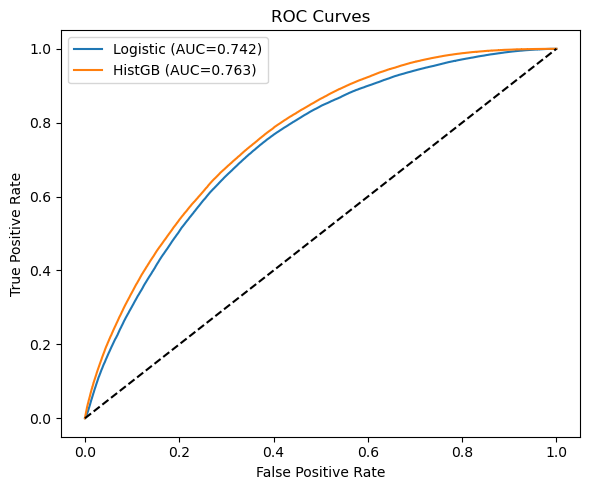

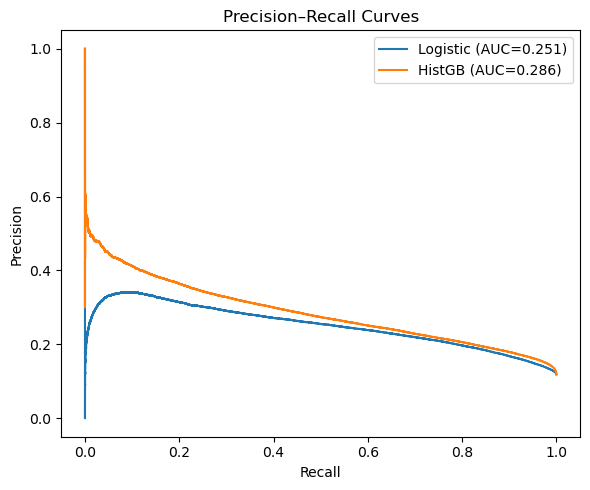

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve

# 预测分数
y_score_log = log_pipe.predict_proba(X_test)[:,1]
y_score_hgb = best_hgb.predict_proba(X_test)[:,1]

# ROC 曲线
fpr_log, tpr_log, _ = roc_curve(y_test, y_score_log)
fpr_hgb, tpr_hgb, _ = roc_curve(y_test, y_score_hgb)

plt.figure(figsize=(6,5))
plt.plot(fpr_log, tpr_log, label=f'Logistic (AUC={roc_log:.3f})')
plt.plot(fpr_hgb, tpr_hgb, label=f'HistGB (AUC={roc_hgb:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.tight_layout()
plt.show()

# PR 曲线
prec_log, rec_log, _ = precision_recall_curve(y_test, y_score_log)
prec_hgb, rec_hgb, _ = precision_recall_curve(y_test, y_score_hgb)

plt.figure(figsize=(6,5))
plt.plot(rec_log, prec_log, label=f'Logistic (AUC={pr_log:.3f})')
plt.plot(rec_hgb, prec_hgb, label=f'HistGB (AUC={pr_hgb:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curves')
plt.legend()
plt.tight_layout()
plt.show()


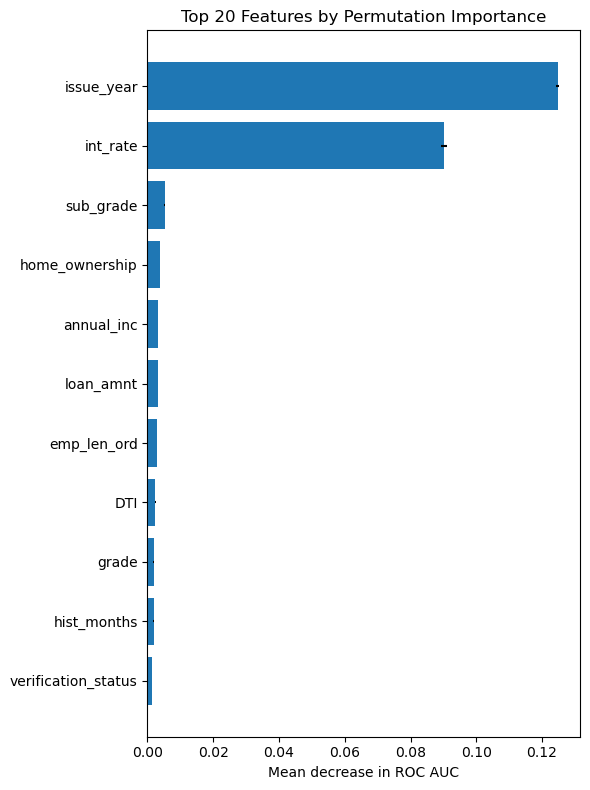

In [23]:
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt

# 假设 best_hgb, X_test, y_test 已经存在

# 1. 特征名用原始输入的列名
feature_names = X_test.columns.tolist()

# 2. 计算 permutation importance
r = permutation_importance(
    best_hgb,
    X_test,
    y_test,
    n_repeats=5,
    random_state=42,
    scoring='roc_auc',
    n_jobs=1
)

# 3. 构造 DataFrame，r.importances_mean, r.importances_std 长度都等于 len(feature_names)
imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': r.importances_mean,
    'importance_std':  r.importances_std
})

# 4. 选 Top20 并可视化（按 importance_mean 降序）
top20 = imp_df.sort_values('importance_mean', ascending=False).head(20)[::-1]

plt.figure(figsize=(6,8))
plt.barh(top20['feature'], top20['importance_mean'], xerr=top20['importance_std'])
plt.xlabel('Mean decrease in ROC AUC')
plt.title('Top 20 Features by Permutation Importance')
plt.tight_layout()
plt.show()


TN=597322, FP=309, FN=80214, TP=366


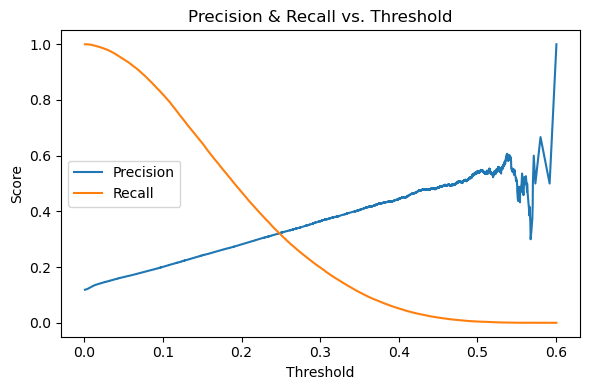

In [24]:
from sklearn.metrics import confusion_matrix, precision_recall_curve

# 1) 先拿到 HistGB 的预测概率
proba = best_hgb.predict_proba(X_test)[:,1]

# 2) 混淆矩阵（阈值 0.5）
pred_label = (proba >= 0.5).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, pred_label).ravel()
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")

# 3) Precision-Recall vs. Threshold
prec, rec, thresh = precision_recall_curve(y_test, proba)
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(thresh, prec[:-1], label='Precision')
plt.plot(thresh, rec[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision & Recall vs. Threshold')
plt.legend()
plt.tight_layout()
plt.show()


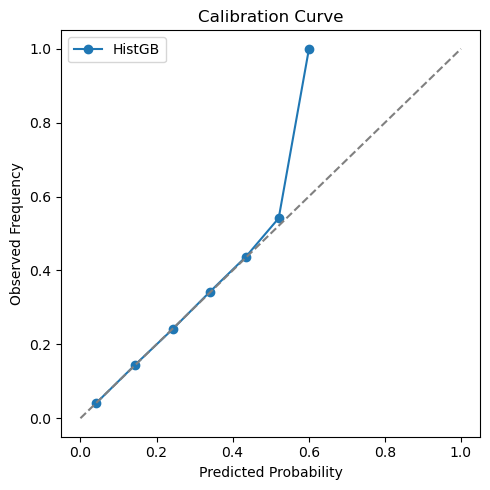

In [25]:
from sklearn.calibration import calibration_curve

# 1) 用同一 proba
prob_true, prob_pred = calibration_curve(y_test, proba, n_bins=10)

# 2) 可视化
plt.figure(figsize=(5,5))
plt.plot(prob_pred, prob_true, marker='o', label='HistGB')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('Predicted Probability')
plt.ylabel('Observed Frequency')
plt.title('Calibration Curve')
plt.legend()
plt.tight_layout()
plt.show()


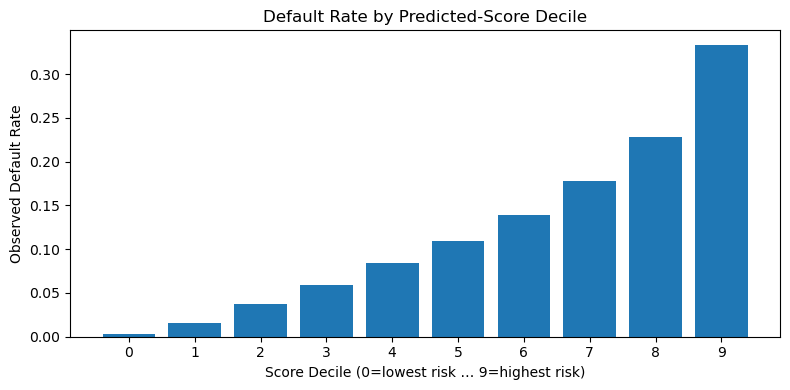

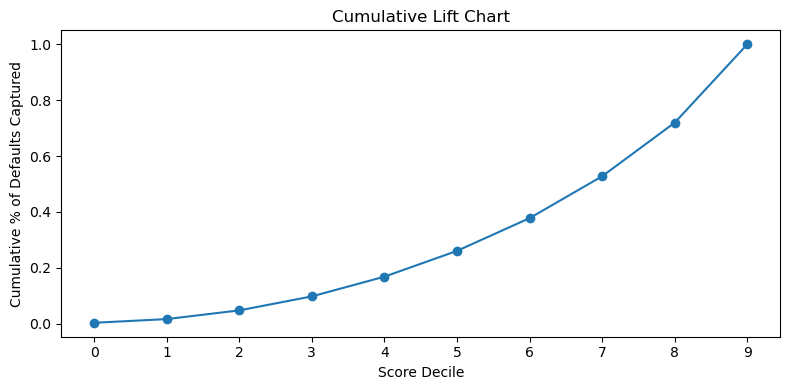

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# 准备 DataFrame
df_test = X_test.copy()
df_test['y_true'] = y_test.values
df_test['y_score'] = best_hgb.predict_proba(X_test)[:,1]

# 分 10 段
df_test['decile'] = pd.qcut(df_test['y_score'], 10, labels=False)

# 计算每段的违约率 & 正例数
decile_stats = (
    df_test
    .groupby('decile')
    .agg(
        count      = ('y_true','size'),
        defaults   = ('y_true','sum'),
        avg_score  = ('y_score','mean')
    )
    .assign(
        default_rate = lambda d: d['defaults'] / d['count'],
        cum_defaults = lambda d: d['defaults'].cumsum(),
        cum_capture  = lambda d: d['cum_defaults'] / d['defaults'].sum()
    )
).reset_index()

# 画违约率柱状图
plt.figure(figsize=(8,4))
plt.bar(decile_stats['decile'], decile_stats['default_rate'])
plt.xticks(range(10))
plt.xlabel('Score Decile (0=lowest risk … 9=highest risk)')
plt.ylabel('Observed Default Rate')
plt.title('Default Rate by Predicted-Score Decile')
plt.tight_layout()
plt.show()

# 画累计捕获率曲线（Lift Chart）
plt.figure(figsize=(8,4))
plt.plot(decile_stats['decile'], decile_stats['cum_capture'], marker='o')
plt.xticks(range(10))
plt.xlabel('Score Decile')
plt.ylabel('Cumulative % of Defaults Captured')
plt.title('Cumulative Lift Chart')
plt.tight_layout()
plt.show()


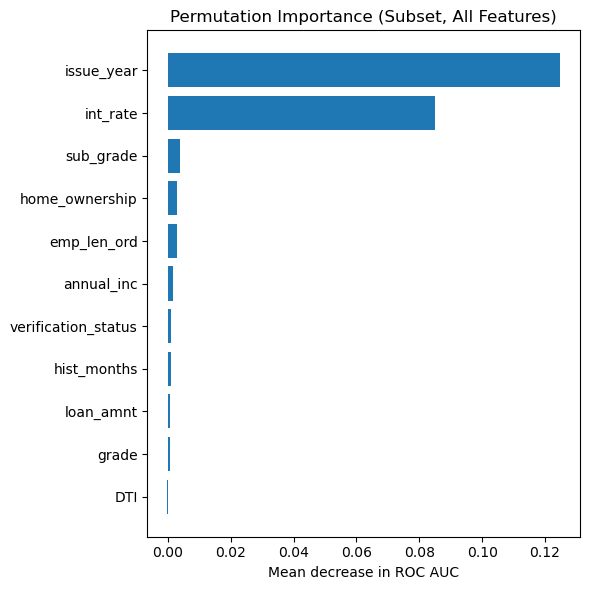

In [35]:
from sklearn.inspection import permutation_importance

# 假设 best_hgb 是你的 HistGradientBoostingClassifier pipeline
# X_test, y_test 是测试集，feature_names 是你的特征名列表

# 子采样（比如2000行加速）
np.random.seed(42)
idx = np.random.choice(len(X_test), 2000, replace=False)
X_sub = X_test.iloc[idx]
y_sub = y_test.iloc[idx]

r = permutation_importance(
    best_hgb, X_sub, y_sub,
    n_repeats=5, random_state=42, scoring='roc_auc', n_jobs=1
)

# 获取特征名（数值+类别，如果有预处理的话）
try:
    num_names = X_sub.columns  # 或者自己定义
except:
    num_names = [f'f{i}' for i in range(X_sub.shape[1])]

imp_df = pd.DataFrame({
    'feature': num_names,
    'importance_mean': r.importances_mean,
    'importance_std':  r.importances_std
}).sort_values('importance_mean', ascending=True)

plt.figure(figsize=(6,6))
plt.barh(imp_df['feature'], imp_df['importance_mean'])
plt.title("Permutation Importance (Subset, All Features)")
plt.xlabel("Mean decrease in ROC AUC")
plt.tight_layout()
plt.show()
